In [1]:
import torch
import numpy as np
import pandas as pd
from model import MovementModel
from train import process_game

In [2]:
df = pd.read_parquet("../../processed_data/men_imbalanced_node_features_numbered.parquet")
df = df.sort_values(['game_id', 'frame_id', 'player_num_label'])
df = df.loc[df["att_team"] != -1]
df["def_team"] = 0
df["off_team"] = 0
df.loc[df["att_team"] == 1, "off_team"] = 1
df.loc[df["att_team"] == 0, "def_team"] = 1
df = df.drop(columns=["att_team"])

In [3]:
df_test = df.loc[df.loc[:, "game_id"] == 10]

In [4]:
window = None
with open("./features.txt", 'r') as f:
    features = f.read().splitlines()

In [5]:
Xs, ys = process_game(df_test, window, features)
Xs = torch.tensor(Xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)

/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_13664/3872912968.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  Xs = torch.tensor(Xs, dtype=torch.float32)


In [6]:
X_mean = np.load("../../models/X_mean.npy")
X_std = np.load("../../models/X_std.npy")
y_mean = np.load("../../models/y_mean.npy")
y_std = np.load("../../models/y_std.npy")

In [7]:
Xs[:, :, :-3] = (Xs[:, :, :-3] - X_mean) / X_std
ys = (ys - y_mean) / y_std

/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_13664/1477219900.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Xs[:, :, :-3] = (Xs[:, :, :-3] - X_mean) / X_std
/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_13664/1477219900.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ys = (ys - y_mean) / y_std


In [8]:
context_dim = Xs[0].shape[-1]
model = MovementModel(2, context_dim, 2, 1, 2)
model.load_state_dict(torch.load("../../models/checkpoint_21.pt"))

/Users/qflovesy/miniconda3/envs/sds625_soccer/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_13664/4205737320.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

<All keys matched successfully>

In [9]:
model.eval()

MovementModel(
  (cvae): cVAE(
    (fc1): Linear(in_features=12, out_features=512, bias=True)
    (fc21): Linear(in_features=512, out_features=2, bias=True)
    (fc22): Linear(in_features=512, out_features=2, bias=True)
    (fc3): Linear(in_features=12, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=2, bias=True)
    (elu): ELU(alpha=1.0)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_aff

In [10]:
device = "mps"
Xs, ys = torch.tensor(Xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)
model.to(device)
Xs = Xs.to(device)
ys = ys.to(device)
with torch.no_grad():
    # Sampling
    trials = 1000
    prior_pred = []
    for _ in range(trials):
        eps = torch.randn(Xs.shape[0], Xs.shape[1], 2)
        eps = eps.to(device)
        recon_loc = model.decode(eps, Xs)
        prior_pred.append(recon_loc)

/var/folders/pf/tk5xdb813879msy13kynrzyr0000gn/T/ipykernel_13664/2106325804.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xs, ys = torch.tensor(Xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)


In [11]:
prior_pred = [arr.cpu().numpy() for arr in prior_pred]
prior_pred = np.stack(prior_pred, axis=0)

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

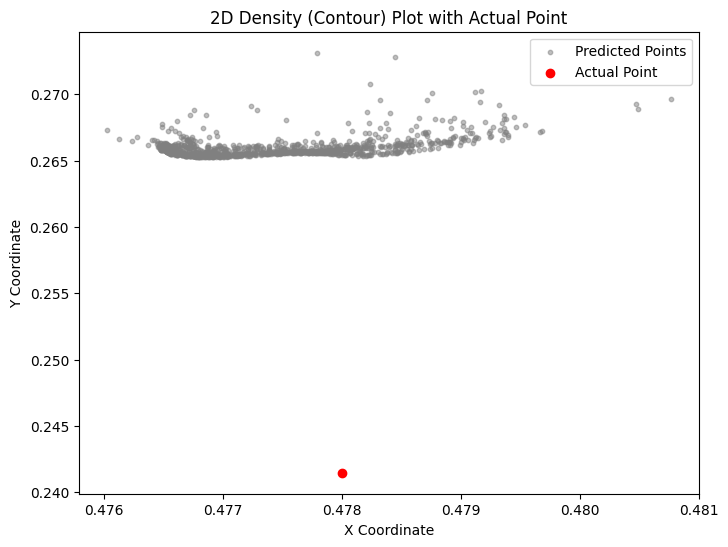

In [18]:
frame_id = 90
player_id = 18
test_point = prior_pred[:, frame_id, player_id, :] * y_std + y_mean
actual_point = ys[frame_id, player_id, :].cpu().numpy() * y_std + y_mean

x_pred = test_point[:, 0]
y_pred = test_point[:, 1]

# Create a Gaussian KDE for density estimation
# kde = gaussian_kde(test_point.T)

# # Define grid for contour plot
# x_min, x_max = x_pred.min() - 1, x_pred.max() + 1
# y_min, y_max = y_pred.min() - 1, y_pred.max() + 1
# x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
# density = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

# Plotting
plt.figure(figsize=(8, 6))
# plt.contourf(x_grid, y_grid, density, levels=30, cmap='Blues')
# plt.colorbar(label='Density')
plt.scatter(x_pred, y_pred, s=10, color='gray', alpha=0.5, label='Predicted Points')
plt.scatter(actual_point[0], actual_point[1], color='red', label='Actual Point', zorder=5)
plt.title("2D Density (Contour) Plot with Actual Point")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [19]:
context_dim

10

In [23]:
Xs_test = np.load("../../processed_data/Xs_test.npy")

In [26]:
Xs_test[:, :, :-3].shape

(19581, 22, 7)